# Pave SFM with Python

![](toy.png)

## relevant libs

In [3]:
# SURF and SIFT is only supported in older version
# pip install opencv-contrib-python==3.4.2.16
# pip install opencv-python==3.4.2.16
import numpy as np
import glob,os,sys
import cv2 as cv 
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import json
import pickle
from scipy.sparse import lil_matrix
import time
from scipy.optimize import least_squares
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R

## load data

In [2]:
image_dir='./matlab-code/data/images/*.png'
files=glob.glob(image_dir)
print('%d images founded' % len(files))

11 images founded


In [10]:
'''
load images as gray images
'''
def read_image(path,ratio=1):
    img=cv.imread(path,0)
    dim=(int(img.shape[1]*ratio),int(img.shape[0]*ratio))
    resized=cv.resize(img,dim)
    return resized

In [4]:
images=[]
for eachimage in files:
    img=read_image(eachimage)
    images.append(img)
print(images[0].shape)

(2048, 3072)


In [28]:
# get calibration matrix
path='matlab-code/data/k/K.txt'
f=open(path,'r')
lines=f.readlines()
K=np.zeros((3,3))
for i in range(3):
    for j in range(3):
        K[i,j]=float(lines[i].split(' ')[j])
print(K)

[[2.75948e+03 0.00000e+00 1.52069e+03]
 [0.00000e+00 2.76416e+03 1.00681e+03]
 [0.00000e+00 0.00000e+00 1.00000e+00]]


## extract features using SURF

### play with SURF on a single image

In [6]:
# Here I set Hessian Threshold to 400
surf = cv.xfeatures2d.SURF_create(400)
sample_img=images[0]
%time kp, des = surf.detectAndCompute(sample_img,None)
print(len(kp))

CPU times: user 4.78 s, sys: 247 ms, total: 5.03 s
Wall time: 2.22 s
8136


In [7]:
kp[0]

<KeyPoint 0x120107900>

In [8]:
des.shape

(8136, 64)

In [9]:
# Here I set Hessian Threshold to 1000
# extended: true - use extended 128-element descriptors; false - use 64-element descriptors
surf = cv.xfeatures2d.SURF_create(hessianThreshold=600,extended=True)
sample_img=images[0]
kp, des = surf.detectAndCompute(sample_img,None)
print(len(kp))

5025


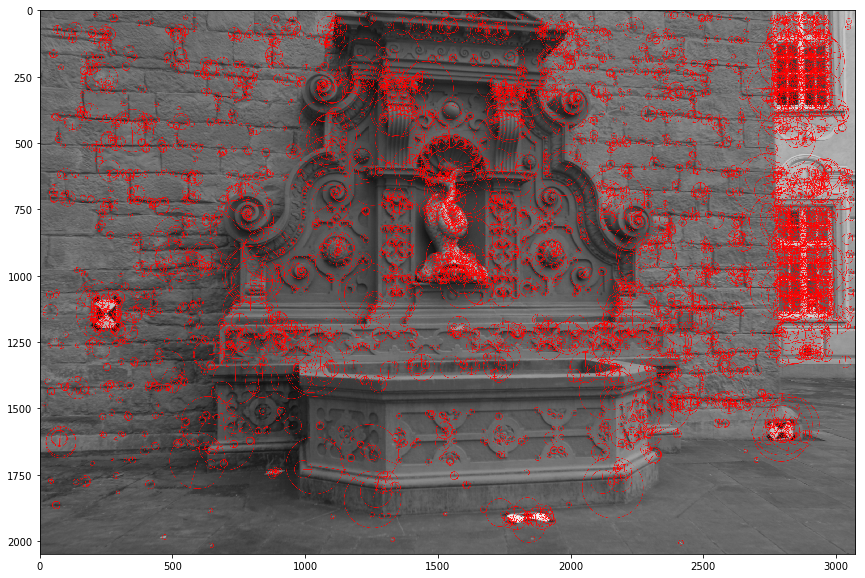

In [10]:
img2 = cv.drawKeypoints(sample_img,kp,None,(255,0,0),4)
plt.figure(figsize=(20,10))
plt.imshow(img2)

In [11]:
print(len(kp),des.shape)

5025 (5025, 128)


### compute keypoints and descriptors for all the images

In [6]:
keypoints,descriptors=[],[]
surf = cv.xfeatures2d.SURF_create(hessianThreshold=400,extended=True)
print('---------numbers of keypoints----------')
for image in images:
    kp, des = surf.detectAndCompute(image,None)
    print(len(kp))
    keypoints.append(kp)
    descriptors.append(des)

---------numbers of keypoints----------
8136
7293
6885
7275
9929
5767
6704
7584
6854
9460
8171


<font color='red'> This part could be optimized using multi-processing

## match keypoints

### play with paired images first

In [19]:
# default brute force matcher with ratio test
bf = cv.BFMatcher()
img1,img2=images[0],images[1]
des1,des2=descriptors[0],descriptors[1]
kp1,kp2=keypoints[0],keypoints[1]
matches = bf.knnMatch(des1,des2,k=2)

In [20]:
print(len(matches),len(matches[0]))

5025 2


The result of matches = bf.match(des1,des2) line is a list of DMatch objects. This DMatch object has following attributes:

- DMatch.distance - Distance between descriptors. The lower, the better it is.
- DMatch.trainIdx - Index of the descriptor in train descriptors
- DMatch.queryIdx - Index of the descriptor in query descriptors
- DMatch.imgIdx - Index of the train image.

1326


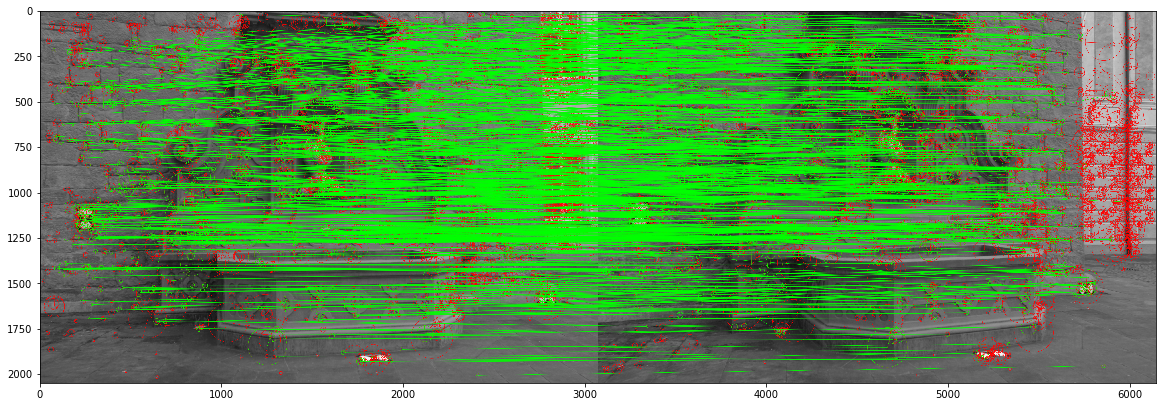

In [32]:
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
print(len(good))
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=4,matchColor = (0,255,0),singlePointColor = (255,0,0))
plt.figure(figsize=(20,10))
plt.imshow(img3)

### compute feature matches for all images

In [7]:
def get_good_matches(descriptors,threshold=0.75):
    bf = cv.BFMatcher()  # Brute Force knn matcher
    n_images=len(descriptors)
    n_good_matches=np.zeros((n_images,n_images)) # store # of good matches between image_i and image_j
    good_matches=[[] for i in range(n_images)] # 2D list
    for i in range(n_images):
        for j in range(n_images):
            if(i!=j):
                des1,des2=descriptors[i],descriptors[j]  # des1——query index; des2 —— train index
                matches = bf.knnMatch(des1,des2,k=2)# find the best and second best match
                good = []
                for m,n in matches:
                    if m.distance < threshold*n.distance:
                        good.append(m)
                n_good_matches[i,j]=len(good)
                good_matches[i].append(good)
            else:
                good_matches[i].append([])
    
    return n_good_matches,good_matches

In [8]:
%time n_good_matches, good_matches=get_good_matches(descriptors)

CPU times: user 9min 59s, sys: 3.15 s, total: 10min 2s
Wall time: 3min 33s


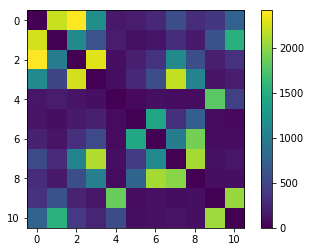

In [9]:
plt.imshow(n_good_matches)
plt.colorbar()

<font color='red'> not necessarily symmetric

## Determine initial pairs

In [10]:
ind = np.unravel_index(np.argmax(n_good_matches, axis=None), n_good_matches.shape)
ind_img1,ind_img2=ind[0],ind[1]
print(ind_img1,ind_img2)

0 2


In [11]:
img1,img2=images[ind_img1],images[ind_img2]
good_match=good_matches[ind_img1][ind_img2]

In [12]:
pts1,pts2=[],[]
for ele in good_match:
    pts1.append(keypoints[ind_img1][ele.queryIdx].pt)
    pts2.append(keypoints[ind_img2][ele.trainIdx].pt)

## two-view geometry

In [13]:
# compute F
pts1=np.int32(pts1)
pts2=np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)

In [14]:
F

array([[ 2.36183566e-10,  5.27897017e-07, -6.00948425e-04],
       [-1.21446412e-07,  2.84565326e-08, -6.35609846e-03],
       [ 1.43906594e-04,  5.58883832e-03,  1.00000000e+00]])

In [15]:
print(pts1.shape,pts2.shape)

(2414, 2) (2414, 2)


In [16]:
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [17]:
print(pts1.shape,pts2.shape)

(2247, 2) (2247, 2)


In [18]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

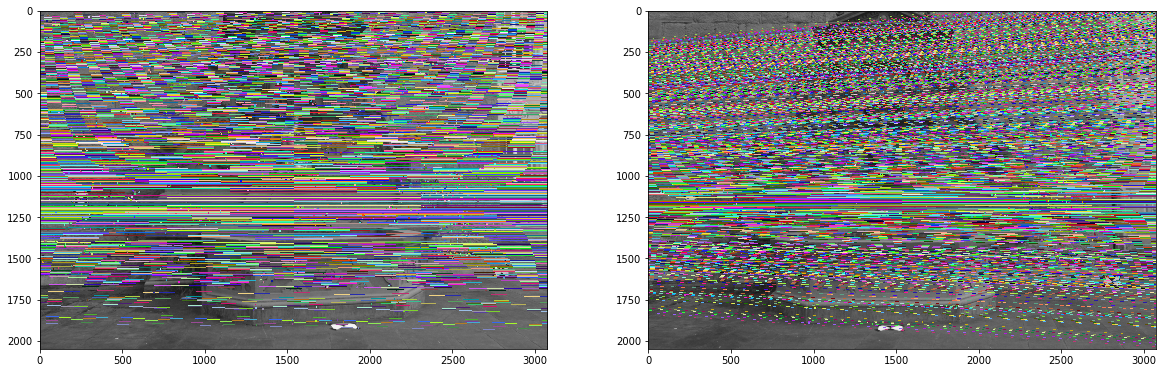

In [19]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [11]:
# linear triangulation
def linearTriangulation(P1,x1s,P2,x2s):
    '''
    Given two projection matrice and homogenous points, we triangulate them to get 3-D points
    '''
    XS=np.zeros((4,x1s.shape[0]))
    err=np.zeros((1,x1s.shape[0]))
    for k in range(x1s.shape[0]):
        r1=x1s[k,0]*P1[2,:]-P1[0,:]
        r2=x1s[k,1]*P1[2,:]-P1[1,:]
        r3=x2s[k,0]*P2[2,:]-P2[0,:]
        r4=x2s[k,1]*P2[2,:]-P2[1,:]
        
        A=np.vstack((r1,r2,r3,r4))
        U,S,Vh=np.linalg.svd(A)
        XS[:,k]=Vh.T[:,-1]/Vh.T[3,3]
        err[0,k]=S[-1]
    return XS,err

In [12]:
def decomposeE(E,x1s,x2s):
    '''
    Given the essential and normalized homogenous points, 
    return the second projection matrix and the index of inliers
    '''
    W=np.array([[0,-1,0],[1,0,0],[0,0,1]])
    [U,S,Vh]=np.linalg.svd(E) # U and Vh is normalized
    
    # extract translation
    t=U[:,2].reshape((-1,1))
    
    # extraction rotation
    R1=np.dot(np.dot(U,W),Vh)
    R2=np.dot(np.dot(U,W.T),Vh)
    if(np.linalg.det(R1)<0):
        R1=-R1
    if(np.linalg.det(R2)<0):
        R2=-R2
    
    # four possible projection matrice
    P1=np.vstack((np.hstack((R1,t)),np.array([0,0,0,1])))
    P2=np.vstack((np.hstack((R1,-t)),np.array([0,0,0,1])))
    P3=np.vstack((np.hstack((R2,t)),np.array([0,0,0,1])))
    P4=np.vstack((np.hstack((R2,-t)),np.array([0,0,0,1])))
    Ps=[P1,P2,P3,P4]
    
    # determine the projection matrix by the maximum inliers
    n_inliers=[]
    ind_inliers=[]
    P=np.eye(4) # the first projection is identical
    for proj_mat in Ps:
        X,_=linearTriangulation(P,x1s,proj_mat,x2s)
        p1X=X
        p2X=np.dot(proj_mat,X)
        
        n_infront1=(p1X[2,:]>0).sum()
        n_infront2=(p2X[2,:]>0).sum()
        
        ind_valid=np.logical_and(p1X[2,:]>0,p2X[2,:]>0)
        ind_inliers.append(ind_valid)
        n_inliers.append(ind_valid.sum())
    
    # determine the best projection matrix by the most reconstructed points in front of the cameras
    n_inliers=np.array(n_inliers)
    ind_proj=n_inliers.argmax() 
    
    ind_inlier=ind_inliers[ind_proj]
    proj_mat=Ps[ind_proj]
    return proj_mat,ind_inlier

In [22]:
# calibrate the homogeneous points
if(pts1.shape[1]==2):
    pts1=np.hstack((pts1,np.ones((pts1.shape[0],1))))
if(pts2.shape[1]==2):
    pts2=np.hstack((pts2,np.ones((pts2.shape[0],1))))
img1_calibrated_inliers=np.dot(np.linalg.inv(K),pts1.T).T
img2_calibrated_inliers=np.dot(np.linalg.inv(K),pts2.T).T
print(img1_calibrated_inliers.shape,img2_calibrated_inliers.shape)

# get Essential matrix from calibration matrix and fundamental matrix
E=np.dot(np.dot(K.T,F),K)

projection_matrix, ind_inliers=decomposeE(E,img1_calibrated_inliers,img2_calibrated_inliers)
print('# pairs: %d' % img1_calibrated_inliers.shape[0])
print('# Reconstructed inliers: %d' % ind_inliers.sum())

(2247, 3) (2247, 3)
# pairs: 2247
# Reconstructed inliers: 2247


In [23]:
P1=np.eye(4)
inliers1=img1_calibrated_inliers[ind_inliers]
inliers2=img2_calibrated_inliers[ind_inliers]
XS,err=linearTriangulation(P1,inliers1,projection_matrix,inliers2)
print(XS.shape)

(4, 2247)


In [24]:
projection_matrix

array([[ 0.98528082,  0.00728579,  0.17078823, -0.97516845],
       [-0.00919011,  0.99990408,  0.01036223,  0.01259191],
       [-0.17069635, -0.01177927,  0.98525327,  0.22110615],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

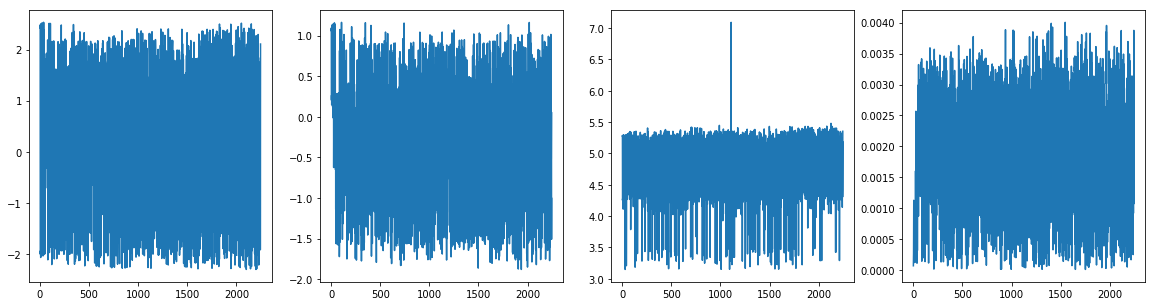

In [25]:
x,y,z=XS[0,:], XS[1,:], XS[2,:]
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(x)
plt.subplot(142)
plt.plot(y)
plt.subplot(143)
plt.plot(z)
plt.subplot(144)
plt.plot(err.flatten())
plt.show()

In [27]:
# import plotly.graph_objects as go
# x,y,z=XS[0,:], XS[1,:], XS[2,:]
# fig = go.Figure(data=[go.Scatter3d(x=x, 
#                                    y=y, 
#                                    z=z,
#                                    mode='markers',
#                                    marker=dict(
#                                        size=2))])
# fig.show()

## bundle adjustment

### correspondence between 3D point, projection matrix, and 2D points

In [28]:
P1=np.eye(4)
P2=projection_matrix
inliers1=img1_calibrated_inliers[ind_inliers]
inliers2=img2_calibrated_inliers[ind_inliers]
XS,err=linearTriangulation(P1,inliers1,P2,inliers2)

In [29]:
XS[:,1]/XS[2,1]

array([0.45925591, 0.20061848, 1.        , 0.18933379])

In [30]:
inliers1[1,:]

array([0.45925682, 0.20049129, 1.        ])

In [31]:
temp=np.dot(projection_matrix,XS)

In [32]:
temp[:,1]/temp[2,1]

array([0.46505952, 0.22097827, 1.        , 0.20006536])

In [33]:
inliers2[1,:]

array([0.46505501, 0.22111238, 1.        ])

### recover rot_vec from rotation matrix

In [34]:
from scipy.spatial.transform import Rotation as R
r = R.from_dcm(np.array([
    [0, -1, 0],
    [1, 0, 0],
    [0, 0, 1]]))
rot_vec=r.as_rotvec()
print(rot_vec)
r=R.from_rotvec(rot_vec)
rotation_matrix=r.as_dcm()
print(rotation_matrix)

[0.         0.         1.57079633]
[[ 3.33066907e-16 -1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  3.33066907e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [13]:
from scipy.spatial.transform import Rotation as R
def proj_matrix_to_camera_vector(proj_mat):
    '''
    decompose the projection matrix to camera paras
    '''
    rot_mat=proj_mat[:3,:3]
    r=R.from_dcm(rot_mat)
    rot_vec=r.as_rotvec()
    t=proj_mat[:3,3]
    camera_vec=np.hstack((rot_vec,t))
    return camera_vec

In [36]:
proj_matrix_to_camera_vector(projection_matrix)

array([-0.01112562,  0.17158853, -0.00827878, -0.97516845,  0.01259191,
        0.22110615])

### only optimize the rotation, translation and reconstruction

In [37]:
P1=np.eye(4)
P2=projection_matrix
inliers1=img1_calibrated_inliers[ind_inliers]
inliers2=img2_calibrated_inliers[ind_inliers]
XS,err=linearTriangulation(P1,inliers1,P2,inliers2)
print(XS.shape)
print(P1)
print(P2)

(4, 2247)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 0.98528082  0.00728579  0.17078823 -0.97516845]
 [-0.00919011  0.99990408  0.01036223  0.01259191]
 [-0.17069635 -0.01177927  0.98525327  0.22110615]
 [ 0.          0.          0.          1.        ]]


In [38]:
# get camera params,  n_cameras x 6
n_cameras=2
camera_params=np.zeros((n_cameras,6))
camera_params[0,:]=proj_matrix_to_camera_vector(P1)
camera_params[1,:]=proj_matrix_to_camera_vector(P2)
print(camera_params.shape)

(2, 6)


In [39]:
# points_3d, n_points, 3
points_3d=XS[:3,:].T
print(points_3d.shape)

(2247, 3)


In [41]:
# get camera_indice
n_cameras=2
n_points=points_3d.shape[0]
camera_indices=[]
for i in range(n_cameras):
    camera_indices.extend([i]*n_points)
camera_indices=np.array(camera_indices)
print(camera_indices.shape)

(4494,)


In [42]:
# get point_ind
point_indices=[]
for i in range(n_cameras):
    for j in range(n_points):
        point_indices.append(j)
point_indices=np.array(point_indices)
print(point_indices.shape)

(4494,)


In [43]:
# get point_2d
pts_2d_1=inliers1[:,:2]
pts_2d_2=inliers2[:,:2]
pts_2d=np.vstack((pts_2d_1,pts_2d_2))
print(pts_2d.shape)

(4494, 2)


In [44]:
# get params
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [14]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

In [15]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj=points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    return points_proj

In [16]:
# get residuals
# n_cameras=2
# n_points=points_3d.shape[0]
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    '''
    get residuals
    '''
    # recover cameras params and points 3d
    camera_params=params[:n_cameras*6].reshape((n_cameras,6))
    points_3d=params[n_cameras*6:].reshape((n_points,3))
    
    # reproject 3d points
    
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

In [48]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, pts_2d)

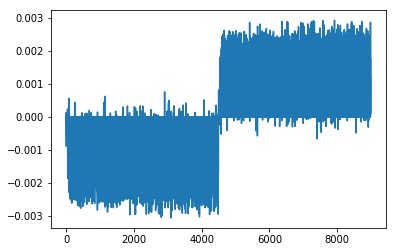

In [49]:
plt.plot(f0)

In [17]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 6 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 6 + s] = 1
        A[2 * i + 1, camera_indices * 6 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 6 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 6 + point_indices * 3 + s] = 1

    return A

In [51]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

In [52]:
t0 = time.time()
res = least_squares(fun, x0,jac='3-point',jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, pts_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5741e-03                                    3.25e+00    
       1              2         3.8008e-05      5.54e-03       4.10e+00       4.62e-02    
       2              3         3.4653e-05      3.35e-06       9.16e-02       1.01e-04    
       3              4         3.4653e-05      2.76e-11       1.61e-04       1.67e-06    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 5.5741e-03, final cost 3.4653e-05, first-order optimality 1.67e-06.


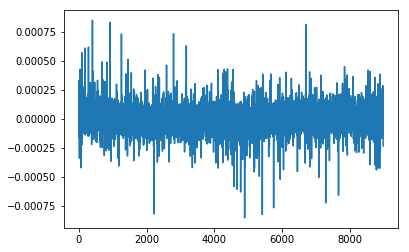

In [53]:
plt.plot(res.fun)

In [54]:
optimized_params=res.x

In [364]:
# # get new pts_3d
# points_3d=optimized_params[n_cameras*6:].reshape((n_points,3))

# x,y,z=points_3d[:,0], points_3d[:,1],points_3d[:,2]
# fig = go.Figure(data=[go.Scatter3d(x=x, 
#                                    y=y, 
#                                    z=z,
#                                    mode='markers',
#                                    marker=dict(
#                                        size=2))])
# fig.update_layout(width=800,height=800)
# fig.show()

In [18]:
def recover_projection_matrix(camera_param):
    rot_vec=camera_param[:3]
    translate_vec=camera_param[3:]
    r=R.from_rotvec(rot_vec)
    rot_matrix=r.as_dcm()
    P=np.eye(4)
    P[:3,:3]=rot_matrix
    P[:3,3]=translate_vec.T
    return P

In [56]:
# get new camera_paras
camera_params=optimized_params[:n_cameras*6].reshape((n_cameras,6))
P1=recover_projection_matrix(camera_params[0])
P2=recover_projection_matrix(camera_params[1])
print(P1)
print(P2)

[[ 9.99998599e-01 -1.11071175e-03 -1.25250520e-03 -7.78242946e-03]
 [ 1.11015724e-03  9.99999286e-01 -4.43333227e-04  7.64696583e-03]
 [ 1.25299672e-03  4.41942128e-04  9.99999117e-01  3.08653806e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.98531768  0.00693956  0.17058987 -0.98192929]
 [-0.00895374  0.99989896  0.01104063  0.00465346]
 [-0.17049601 -0.01240595  0.98528027  0.20602615]
 [ 0.          0.          0.          1.        ]]


## P3P

### find next image

In [57]:
n_good_matches

array([[   0., 2211., 2414., 1191.,  167.,  189.,  270.,  573.,  309.,
         395.,  762.],
       [2250.,    0., 1154.,  618.,  195.,  106.,  140.,  318.,  176.,
         607., 1537.],
       [2406., 1027.,    0., 2297.,  100.,  202.,  355., 1141.,  578.,
         206.,  343.],
       [1148.,  504., 2251.,    0.,   86.,  279.,  578., 2196., 1092.,
         128.,  195.],
       [ 142.,  188.,  126.,  101.,    0.,   66.,  103.,   84.,   84.,
        1792.,  462.],
       [ 125.,   96.,  176.,  224.,   70.,    0., 1415.,  332.,  723.,
          79.,   62.],
       [ 224.,  125.,  321.,  532.,   72., 1450.,    0., 1024., 1905.,
          84.,   79.],
       [ 541.,  283., 1091., 2130.,  102.,  424., 1157.,    0., 2093.,
         105.,  147.],
       [ 302.,  177.,  577., 1031.,   71.,  781., 2086., 1986.,    0.,
          89.,  102.],
       [ 344.,  609.,  229.,  149., 1850.,   83.,  111.,   83.,  102.,
           0., 2037.],
       [ 768., 1538.,  400.,  248.,  558.,   94.,  109.,  13

In [58]:
print(n_good_matches.shape)

(11, 11)


In [59]:
# initial query and train indice
query_indice=[ele.queryIdx for ele in good_match] # img1
train_indice=[ele.trainIdx for ele in good_match] # img2

# filter by ransacFundamental and decomposeE
query_indice=np.array(query_indice)
train_indice=np.array(train_indice)

mask_F=mask.ravel()==1
mask_E=ind_inliers
query_indice=query_indice[mask_F][mask_E]
train_indice=train_indice[mask_F][mask_E]

In [193]:
print(len(query_indice),len(set(query_indice)))
print(len(train_indice),len(set(train_indice)))

743 743
743 667


In [60]:
print(ind_img1,ind_img2)

0 2


In [63]:
ind_registered_cameras=[]
ind_registered_cameras.append(ind_img1)
ind_registered_cameras.append(ind_img2)
print(ind_registered_cameras)

[0, 2]


In [68]:
# find next image with most overlapping 2D pts
img1_matches=good_matches[ind_img1]
n_overlaps=[]
ind_overlaps=[]
for match in img1_matches:
    ind_matches=[ele.queryIdx for ele in match]
    ind_overlap=[ele for ele in ind_matches if ele in query_indice ]
    n_overlap=len(ind_overlap)
    n_overlaps.append(n_overlap)
n_overlaps=np.array(n_overlaps)
n_overlaps[ind_registered_cameras]=0
print(np.argmax(n_overlaps),n_overlaps[np.argmax(n_overlaps)])

1 945


In [69]:
# find next image with most overlapping 2D pts
img2_matches=good_matches[ind_img2]
n_overlaps=[]
ind_overlaps=[]
for match in img2_matches:
    ind_matches=[ele.queryIdx for ele in match]
    ind_overlap=[ele for ele in ind_matches if ele in query_indice ]
    n_overlap=len(ind_overlap)
    n_overlaps.append(n_overlap)
    ind_overlaps.append(ind_overlap)
n_overlaps=np.array(n_overlaps)
n_overlaps[ind_registered_cameras]=0
print(np.argmax(n_overlaps),n_overlaps[np.argmax(n_overlaps)])

3 663


In [85]:
points_3d=optimized_params[n_cameras*6:].reshape((n_points,3))
ind_img1=ind_img1
ind_img2=1
query_indice=query_indice

c_match=good_matches[ind_img1][ind_img2]

# get new pts 2d
new_pts=[keypoints[ind_img2][ele.trainIdx].pt for ele in c_match if ele.queryIdx in query_indice]
new_pts_2d=np.int32(new_pts)

# get corresponding 3d pts
c_query_indice=[ele.queryIdx for ele in c_match]
mask_3d=[True if ele in c_query_indice else False for ele in query_indice]
new_pts_3d=points_3d[mask_3d]
new_pts_2d=new_pts_2d.astype(np.float64)

In [109]:
# ransac PnP
# recover projection matrix
new_camera_params=np.hstack((rvec.flatten(),tvec.flatten()))
new_proj_matrix=recover_projection_matrix(new_camera_params)
print(new_proj_matrix)
_,rvec,tvec,ind_inliers=cv.solvePnPRansac(objectPoints = new_pts_3d, imagePoints = new_pts_2d, cameraMatrix = K, distCoeffs = None)

In [107]:
def recover_projection_matrix(camera_param):
    rot_vec=camera_param[:3]
    translate_vec=camera_param[3:]
    r=R.from_rotvec(rot_vec)
    rot_matrix=r.as_dcm()
    P=np.eye(4)
    P[:3,:3]=rot_matrix
    P[:3,3]=translate_vec.T
    return P

In [117]:
# recover projection matrix
new_camera_params=np.hstack((rvec.flatten(),tvec.flatten()))
new_proj_matrix=recover_projection_matrix(new_camera_params)
print(new_proj_matrix)

[[ 0.98070746 -0.01039247 -0.19520468  0.99779129]
 [ 0.00791578  0.99987803 -0.01346352  0.02151358]
 [ 0.19532079  0.01165858  0.98067011  0.00202274]
 [ 0.          0.          0.          1.        ]]


In [ ]:
# update existing observations
new_camera_params=new_camera_params[np.newaxis,:]
camera_params=np.vstack((camera_params,new_camera_params))

# 


In [119]:
new_camera_params.shape

(1, 6)

In [164]:
class SFM_Params:
    def __init__(self,img_dir=None,threshold=0.75,hessianThreshold=800):
        self.img_dir=img_dir
        files=sorted(glob.glob(self.img_dir))
        self.files=files
        self.n_cameras=len(files) # number of cameras
        self.n_good_matches=np.zeros((self.n_cameras,self.n_cameras))  # number of good matches between each camera
        
        self.surf = cv.xfeatures2d.SURF_create(hessianThreshold=hessianThreshold,extended=True)   # surf detector
        self.threshold=threshold  # threshold used for filtering the pairs
        self.bf = cv.BFMatcher()  # Brute Force knn matcher
        
        self.c_match=None  # current camera pair
        self.c_ind_img1=0  # index of the first camera
        self.c_ind_img2=0  # index of the second camera
        self.ind_registered_cameras=[]
        self.reconstructed_3d_pts=[]

In [165]:
# init the global parasm for my structure from motion pipeline
image_dir='./matlab-code/data/images/*.png'
config=SFM_Params(image_dir,hessianThreshold=400)

In [166]:
dict_cameras={}
n_cameras=config.n_cameras
# init dict_cameras
for i in range(n_cameras):
    dict_cameras[i]={}

# load images
for i in range(n_cameras):
    img_path=config.files[i]
    img=read_image(img_path)
    dict_cameras[i]['img']=img

In [167]:
# get features
for i in range(n_cameras):
    img=dict_cameras[i]['img']
    kp, des = config.surf.detectAndCompute(img,None)
    dict_cameras[i]['kp'],dict_cameras[i]['des']=kp,des

In [168]:
# get feature matches
for i in range(n_cameras):
    dict_cameras[i]['matches']=[] # matches is a list
    des1=dict_cameras[i]['des']  # descriptors of the first camera
    for j in range(n_cameras):
        if(i!=j):
            des2=dict_cameras[j]['des']  # des1——query index; des2 —— train index
            matches = config.bf.knnMatch(des1,des2,k=2)# find the best and second best match
            matches=sorted(matches,key=lambda x:x[0].distance) # sort by the distance first, ascending order
            good_match = []
            ind_train=[] # filter the cases when multiple queryIdx point to the same trainIdx
            for m,n in matches:
                if m.distance < config.threshold*n.distance and m.trainIdx not in ind_train:
                    good_match.append(m)
                    ind_train.append(m.trainIdx)
            config.n_good_matches[i,j]=len(good_match)
            dict_cameras[i]['matches'].append(good_match)
        else:
            dict_cameras[i]['matches'].append([])
print(config.n_good_matches)

[[   0. 1293.  645.  308.  204.  159.  110.   80.   52.   69.   64.]
 [1327.    0. 1759.  958.  477.  294.  190.  105.   67.   76.   61.]
 [ 677. 1852.    0. 1825.  912.  511.  254.  157.   78.   75.   58.]
 [ 362. 1032. 1901.    0. 1936.  974.  479.  247.  113.   86.   87.]
 [ 233.  514.  958. 1980.    0. 2039. 1033.  445.  159.  109.   71.]
 [ 173.  315.  510. 1007. 2071.    0. 2202.  926.  295.  181.   84.]
 [ 148.  217.  271.  495. 1041. 2194.    0. 2005.  648.  295.  122.]
 [  93.  124.  154.  236.  480.  994. 2024.    0. 1366.  522.  156.]
 [  74.   75.   76.  101.  191.  326.  639. 1349.    0. 1784.  466.]
 [  70.   87.   85.   76.  131.  198.  286.  536. 1785.    0. 1618.]
 [  60.   84.   70.   70.   82.  107.  121.  161.  416. 1596.    0.]]


In [205]:
for i in range(config.n_cameras):
    dict_cameras[i]['camera']=None
    dict_cameras[i]['points_indice']=None
    dict_cameras[i]['registered_2d_indice']=None
config.ind_registered_cameras=[]
config.reconstructed_3d_pts=None

In [206]:
# determine initial pair
ind = np.unravel_index(np.argmax(config.n_good_matches, axis=None), config.n_good_matches.shape)
config.c_ind_img1=ind[0]
config.c_ind_img2=ind[1]
print(ind,np.max(config.n_good_matches))

(5, 6) 2202.0


In [207]:
# set current match
ind_img1=config.c_ind_img1
ind_img2=config.c_ind_img2
config.c_match=dict_cameras[ind_img1]['matches'][ind_img2]


# recover 2D pts
pts1,pts2=[],[]
for ele in config.c_match:
    pts1.append(dict_cameras[ind_img1]['kp'][ele.queryIdx].pt)
    pts2.append(dict_cameras[ind_img2]['kp'][ele.trainIdx].pt)    
pts1=np.int32(pts1)
pts2=np.int32(pts2)

# compute F
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)

# filter the outliers 
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# calibrate the homogeneous points
if(pts1.shape[1]==2):
    pts1=np.hstack((pts1,np.ones((pts1.shape[0],1))))
if(pts2.shape[1]==2):
    pts2=np.hstack((pts2,np.ones((pts2.shape[0],1))))
img1_calibrated_inliers=np.dot(np.linalg.inv(K),pts1.T).T
img2_calibrated_inliers=np.dot(np.linalg.inv(K),pts2.T).T

# get Essential matrix from calibration matrix and fundamental matrix
E=np.dot(np.dot(K.T,F),K)

projection_matrix, ind_inliers=decomposeE(E,img1_calibrated_inliers,img2_calibrated_inliers)
print('Use camera %d and camera %d to initialize' % (ind_img1,ind_img2))
print('# pairs: %d' % img1_calibrated_inliers.shape[0])
print('# Reconstructed inliers: %d' % ind_inliers.sum())

Use camera 5 and camera 6 to initialize
# pairs: 2115
# Reconstructed inliers: 2115


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9592e-03                                    1.81e+00    
       1              2         3.0565e-05      2.93e-03       3.63e+00       1.71e-02    
       2              3         2.9442e-05      1.12e-06       1.40e-01       5.17e-05    
       3              4         2.9442e-05      2.01e-11       8.61e-04       1.37e-06    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 2.9592e-03, final cost 2.9442e-05, first-order optimality 1.37e-06.


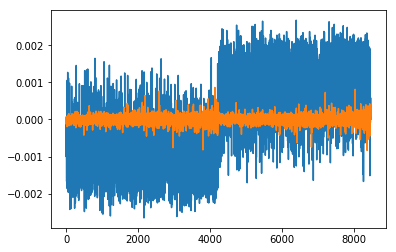

In [208]:
# bundle adjustment
P1=np.eye(4)
P2=projection_matrix
inliers1=img1_calibrated_inliers[ind_inliers]
inliers2=img2_calibrated_inliers[ind_inliers]
XS,_=linearTriangulation(P1,inliers1,P2,inliers2)

n_cameras=2
n_points=XS.shape[1]

# get camera params,  n_cameras x 6
camera_params=np.zeros((n_cameras,6))
camera_params[0,:]=proj_matrix_to_camera_vector(P1)
camera_params[1,:]=proj_matrix_to_camera_vector(P2)

# points_3d, n_points x 3
points_3d=XS[:3,:].T

# get camera_indice
camera_indices=[]
for i in range(n_cameras):
    camera_indices.extend([i]*n_points)
camera_indices=np.array(camera_indices)

# get points_ind
points_indices=[]
for i in range(n_cameras):
    for j in range(n_points):
        points_indices.append(j)
points_indices=np.array(points_indices)

# get point_2d
pts_2d_1=inliers1[:,:2]
pts_2d_2=inliers2[:,:2]
pts_2d=np.vstack((pts_2d_1,pts_2d_2))

# get params
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
f0 = fun(x0, n_cameras, n_points, camera_indices, points_indices, pts_2d)
plt.plot(f0)

# optimize
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, points_indices)
t0 = time.time()
res = least_squares(fun, x0,jac='3-point',jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, points_indices, pts_2d))
t1 = time.time()
plt.plot(res.fun)

In [209]:
config.ind_registered_cameras.append(ind_img1)
config.ind_registered_cameras.append(ind_img2)

# update the optimized parameters
optimized_params=res.x
# get new camera_paras
camera_params=optimized_params[:n_cameras*6].reshape((n_cameras,6))

# get new pts_3d
points_3d=optimized_params[n_cameras*6:].reshape((n_points,3))

In [210]:
# initial query and train indice
query_indice=[ele.queryIdx for ele in config.c_match] # img1
train_indice=[ele.trainIdx for ele in config.c_match] # img2

# filter by ransacFundamental and decomposeE
query_indice=np.array(query_indice)
train_indice=np.array(train_indice)

mask_F=mask.ravel()==1
mask_E=ind_inliers
query_indice=query_indice[mask_F][mask_E]
train_indice=train_indice[mask_F][mask_E]

In [211]:
# update the camera dictionary
dict_cameras[ind_img1]['camera']=camera_params[0]
dict_cameras[ind_img1]['registered_2d_indice']=query_indice # indice of the reconstructed 2d points
dict_cameras[ind_img1]['points_indice']=np.arange(len(query_indice)) # indice mapping to the 3D points
dict_cameras[ind_img2]['camera']=camera_params[1]
dict_cameras[ind_img2]['registered_2d_indice']=train_indice
dict_cameras[ind_img2]['points_indice']=np.arange(len(train_indice))

In [212]:
print(query_indice.shape)
print(np.arange(10).shape)

(2115,)
(10,)


In [213]:
# update the global configuration
config.reconstructed_3d_pts=points_3d

In [214]:
for i in range(config.n_cameras-2): # loop through all the left cameras
    max_overlapping=0
    ind_3d_camera=0 # camera used to provide 3d points
    ind_2d_camera=0 # camera  used to provide 2d points
    for j in config.ind_registered_cameras:   # find the registered cameras with the maximum overlap points
        c_matches=dict_cameras[j]['matches'] # current matches with all the other cameras 
        ind_registered_query=dict_cameras[j]['registered_2d_indice'] # indice of reconstructed points
        for ii in range(config.n_cameras):
            if(ii not in config.ind_registered_cameras): # only inspect non-registered cameras
                c_match=c_matches[ii]
                ind_overlap=[ele for ele in c_match if ele.queryIdx in ind_registered_query]
                n_overlap=len(ind_overlap)
                # update the maximum overlap
                if(n_overlap>max_overlapping):
                    max_overlapping=n_overlap
                    ind_3d_camera=j
                    ind_2d_camera=ii
    print('Using %d points to register camera %d by camera %d' % (max_overlapping,ind_2d_camera,ind_3d_camera))
    
    c_match=dict_cameras[ind_3d_camera]['matches'][ind_2d_camera]
    camera_3d=dict_cameras[ind_3d_camera]
    camera_2d=dict_cameras[ind_2d_camera]
    
    # get 2D points
    indice_2d_points=[ele.trainIdx for ele in c_match if ele.queryIdx in camera_3d['registered_2d_indice']]
    new_pts_2d=[camera_2d['kp'][ele].pt for ele in indice_2d_points]
    new_pts_2d=np.float64(new_pts_2d)   
    
    # get 3D points, we link the 2D indice of camera_3d to the points_indice to locate 3D points in world coordinate frame
    # these indice also points to the reconstructed points
    indice_temp=[ele.queryIdx for ele in c_match if ele.trainIdx in indice_2d_points] 
    indice_3d_points=[]  #  point to the reconstructed 3D points
    for ele in indice_temp:
        ind_3d=np.where(camera_3d['registered_2d_indice']==ele)[0][0]
        indice_3d_points.append(camera_3d['points_indice'][ind_3d])
    existing_pts_3d=config.reconstructed_3d_pts[indice_3d_points]
    
    # ransacPnP
    assert existing_pts_3d.shape[0]==new_pts_2d.shape[0]
    _,rvec,tvec,ind_inliers=cv.solvePnPRansac(objectPoints = existing_pts_3d, imagePoints = new_pts_2d, cameraMatrix = K, distCoeffs = None)
    new_camera_params=np.hstack((rvec.flatten(),tvec.flatten()))
    new_proj_matrix=recover_projection_matrix(new_camera_params)
    
    # filter the outliers from PnP
    indice_2d_points=np.array(indice_2d_points)[ind_inliers]
    indice_3d_points=np.array(indice_3d_points)[ind_inliers]
    
    print('Use %d points to compute PnP, get %d inliers' % (existing_pts_3d.shape[0],len(ind_inliers)))
    
    # update the parameters of new camera
    dict_cameras[ind_2d_camera]['camera']=new_camera_params
    dict_cameras[ind_2d_camera]['registered_2d_indice']=indice_2d_points.flatten()
    dict_cameras[ind_2d_camera]['points_indice']=indice_3d_points.flatten()
    
    # reconstruct the left 2D pts 
    c_matches=dict_cameras[ind_2d_camera]['matches']
    P1=recover_projection_matrix(dict_cameras[ind_2d_camera]['camera'])
    for j in config.ind_registered_cameras:
        c_match=c_matches[j]
        P2=recover_projection_matrix(dict_cameras[j]['camera'])
        # only choose those haven't been reconstructed
        pts1,pts2=[],[]
        indice_1,indice_2=[],[]
        for ele in c_match:
            if(ele.trainIdx not in dict_cameras[j]['registered_2d_indice']):
                pts1.append(dict_cameras[ind_2d_camera]['kp'][ele.queryIdx].pt)
                pts2.append(dict_cameras[j]['kp'][ele.trainIdx].pt)
                indice_1.append(ele.queryIdx)
                indice_2.append(ele.trainIdx)
        print('in total %d pairs for camera %d and camera %d' % (len(c_match),ind_2d_camera,j))
        if(len(pts1)!=0 and len(pts2)!=0):
            print('get %d pairs for camera %d and camera %d' % (len(pts1),ind_2d_camera,j))
            pts1=np.float64(pts1)
            pts2=np.float64(pts2)
            indice_1=np.array(indice_1)
            indice_2=np.array(indice_2)

            # reconstruct 3D points
            # calibrate the homogeneous points
            if(pts1.shape[1]==2):
                pts1=np.hstack((pts1,np.ones((pts1.shape[0],1))))
            if(pts2.shape[1]==2):
                pts2=np.hstack((pts2,np.ones((pts2.shape[0],1))))
            inliers1=np.dot(np.linalg.inv(K),pts1.T).T
            inliers2=np.dot(np.linalg.inv(K),pts2.T).T
            XS,_=linearTriangulation(P1,inliers1,P2,inliers2)
            
#             projected_1=np.dot(P1,XS)
#             projected_1=projected_1[:2,:]/projected_1[2,:]
#             projected_1=projected_1.T
#             residuals=(projected_1-inliers1[:,:2]).ravel()
#             fig=plt.figure()
#             plt.plot(residuals)
            
#             projected_1=np.dot(P2,XS)
#             projected_1=projected_1[:2,:]/projected_1[2,:]
#             projected_1=projected_1.T
#             residuals=(projected_1-inliers2[:,:2]).ravel()
#             fig=plt.figure()
#             plt.plot(residuals)
            

            # update the camera dict
            tmp=dict_cameras[ind_2d_camera]['registered_2d_indice']
            dict_cameras[ind_2d_camera]['registered_2d_indice']=np.hstack((tmp,indice_1))
            tmp=dict_cameras[j]['registered_2d_indice']
            dict_cameras[j]['registered_2d_indice']=np.hstack((tmp,indice_2))

            # update global 3D points
            new_pts_3d=XS[:3,:].T
            n_exist_pts_3d=config.reconstructed_3d_pts.shape[0]
            tmp=config.reconstructed_3d_pts
            config.reconstructed_3d_pts=np.vstack((tmp,new_pts_3d))

            n_new_pts_3d=new_pts_3d.shape[0]
            new_points_indice=np.arange(n_exist_pts_3d,n_exist_pts_3d+n_new_pts_3d)
            tmp=dict_cameras[ind_2d_camera]['points_indice']
            dict_cameras[ind_2d_camera]['points_indice']=np.hstack((tmp,new_points_indice))
            tmp=dict_cameras[j]['points_indice']
            dict_cameras[j]['points_indice']=np.hstack((tmp,new_points_indice))
    
    ###################
    # run BA
    ###################
    config.ind_registered_cameras.append(ind_2d_camera)
    n_cameras=len(config.ind_registered_cameras)
    n_points=config.reconstructed_3d_pts.shape[0]
    
    
    # points_3d, n_points x 3
    points_3d=config.reconstructed_3d_pts
    
    # get camera params,points_2d
    # get camera_indice
    camera_params=np.zeros((n_cameras,6))
    camera_indices=[]
    points_indices=[]
    points_2d=[]
    for j in range(n_cameras):
        ind_camera=config.ind_registered_cameras[j]
        
        camera_params[j,:]=dict_cameras[ind_camera]['camera']
        camera_indices.extend([j]*dict_cameras[ind_camera]['registered_2d_indice'].shape[0])
        points_indices.extend(dict_cameras[ind_camera]['points_indice'].tolist())
        
        for ele in dict_cameras[ind_camera]['registered_2d_indice']:
            points_2d.append(dict_cameras[ind_camera]['kp'][ele].pt)
            
    points_2d=np.float64(points_2d)
    camera_indices=np.array(camera_indices)  
    points_indices=np.array(points_indices)  
    
    # calibrate the 2d image pts to calculate residual
    if(points_2d.shape[1]==2):
        points_2d=np.hstack((points_2d,np.ones((points_2d.shape[0],1))))
    points_2d=np.dot(np.linalg.inv(K),points_2d.T).T
    points_2d=points_2d[:,:2]
    
    # get params
    x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
    f0 = fun(x0, n_cameras, n_points, camera_indices, points_indices, points_2d)
#     plt.figure()
#     plt.plot(f0)

    # optimize
    A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, points_indices)
    t0 = time.time()
    res = least_squares(fun, x0,jac='3-point',jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                        args=(n_cameras, n_points, camera_indices, points_indices, points_2d))
#     t1 = time.time()
#     plt.figure()
#     plt.plot(res.fun)
    
    # update results
    optimized_params=res.x   
    camera_params=optimized_params[:n_cameras*6].reshape((n_cameras,6))
    points_3d=optimized_params[n_cameras*6:].reshape((n_points,3))
    for j in range(n_cameras):
        ind_camera=config.ind_registered_cameras[j]
        dict_cameras[ind_camera]['camera']=camera_params[j,:]
    config.reconstructed_3d_pts=points_3d
    break

Using 923 points to register camera 4 by camera 5
Use 923 points to compute PnP, get 898 inliers
in total 2039 pairs for camera 4 and camera 5
get 1130 pairs for camera 4 and camera 5
in total 1033 pairs for camera 4 and camera 6
get 309 pairs for camera 4 and camera 6
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.1345e-01                                    1.28e+00    
       1              2         7.8012e-01      3.33e-02       1.86e+02       3.53e-02    
       2              3         7.7934e-01      7.83e-04       3.84e+01       1.89e-02    
       3              4         7.7927e-01      7.50e-05       2.07e+01       3.06e-03    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 8.1345e-01, final cost 7.7927e-01, first-order optimality 3.06e-03.


In [215]:
# get new pts_3d
points_3d=config.reconstructed_3d_pts
x,y,z=points_3d[:,0], points_3d[:,1],points_3d[:,2]
# filter_ind=np.abs(x)<10
# x=x[filter_ind]
# y=y[filter_ind]
# z=z[filter_ind]

fig = go.Figure(data=[go.Scatter3d(x=x, 
                                   y=y, 
                                   z=z,
                                   mode='markers',
                                   marker=dict(
                                       size=2))])
fig.update_layout(width=500,height=500)
fig.show()

(array([1.0000e+00, 1.0000e+00, 2.0000e+00, 1.3651e+04, 5.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-8488.99337647, -6328.10742576, -4167.22147505, -2006.33552434,
          154.55042637,  2315.43637708,  4476.32232779,  6637.2082785 ,
         8798.09422921, 10958.98017992, 13119.86613063]),
 <a list of 10 Patch objects>)

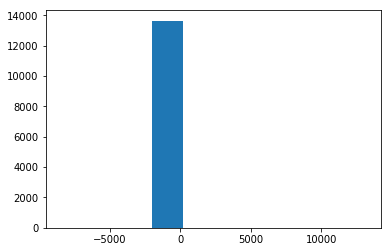

In [197]:
plt.hist(points_3d[:,0])

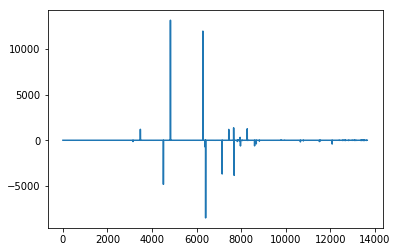

In [194]:
plt.plot(points_3d[:,0])

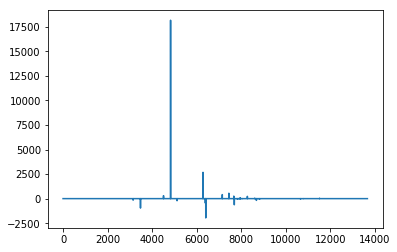

In [195]:
plt.plot(points_3d[:,1])

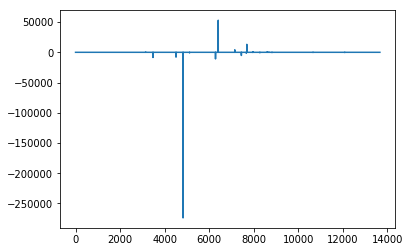

In [196]:
plt.plot(points_3d[:,2])